In [1]:
import torch
import matplotlib.pyplot as plt

from typing import List, Dict
from hydra import initialize, compose
from hydra.utils import instantiate
from pytorch_lightning.utilities import move_data_to_device

from bliss.surveys.dc2 import DC2DataModule
from case_studies.dc2_new_diffusion.utils.encoder import DiffusionEncoder

In [2]:
model_name = "exp_01-25-2"
model_check_point_name = "encoder_48.ckpt"
model_path = f"../../../bliss_output/DC2_latent_diffusion_exp/{model_name}/checkpoints/{model_check_point_name}"
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
with initialize(config_path="./latent_diffusion_config", version_base=None):
    new_diffusion_notebook_cfg = compose("latent_diffusion_notebook_config")

In [3]:
tile_slen = new_diffusion_notebook_cfg.surveys.dc2.tile_slen
max_sources_per_tile = new_diffusion_notebook_cfg.surveys.dc2.max_sources_per_tile
r_band_min_flux = new_diffusion_notebook_cfg.notebook_var.r_band_min_flux

dc2: DC2DataModule = instantiate(new_diffusion_notebook_cfg.surveys.dc2)
dc2.setup(stage="validate")
dc2_val_dataloader = dc2.val_dataloader()

bliss_encoder: DiffusionEncoder = instantiate(new_diffusion_notebook_cfg.encoder).to(device=device)
pretrained_weights = torch.load(model_path, map_location=device)["state_dict"]
bliss_encoder.load_state_dict(pretrained_weights)
bliss_encoder.eval();

In [4]:
print(bliss_encoder.ddim_steps)
print(bliss_encoder.ddim_objective)
print(bliss_encoder.ddim_beta_schedule)

5
pred_x0
linear


In [5]:
print(bliss_encoder.catalog_parser.factors[0].threshold)

0.0


In [6]:
bliss_encoder.catalog_parser.factors[0].threshold = 0.0

In [7]:
dc2_val_dataloader_iter = iter(dc2_val_dataloader)

In [8]:
latent_scale = bliss_encoder.detection_diffusion.scale
encoder_output_min = bliss_encoder.detection_diffusion.encoder_output_min
encoder_output_max = bliss_encoder.detection_diffusion.encoder_output_max

In [9]:
def plot_diffusion_results(diffusion_results: List[Dict], true_images: torch.Tensor, image_num: int):
    ddim_steps = len(diffusion_results)
    fig, axes = plt.subplots(image_num, ddim_steps + 1,
                             sharex="all", sharey="all",
                             figsize=((ddim_steps + 1) * 3, image_num * 3))
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

    images = []
    for step in range(ddim_steps):
        images.append(diffusion_results[step]["x_start"][:image_num])
    images.append(true_images[:image_num])
    images = torch.stack(images, dim=0)  # (ddim_steps, image_num, c, h, w)
    
    images /= latent_scale
    images = (images + 1) / 2 * (encoder_output_max - encoder_output_min) + encoder_output_min
    images = (images.norm(dim=2, p=2) + 1).log().numpy()  # (ddim_steps, image_num, h, w)
    vmin = images.min()
    vmax = images.max()
    for i in range(image_num):
        for j in range(ddim_steps + 1):
            ax: plt.Axes = axes[i, j]
            im = ax.imshow(images[j, i], cmap="viridis", interpolation="nearest",
                          vmin=vmin, vmax=vmax)
            if j == 0:
                ax.set_ylabel(f"Image:{i}")
            if i == image_num - 1:
                if j == ddim_steps:
                    ax.set_xlabel(f"Truth")
                else:
                    ax.set_xlabel(f"Step:{j + 1}")
        ax: plt.Axes = axes[i, -1]

    fig.colorbar(im, cax=cbar_ax)
    # fig.supxlabel("DDIM Steps")
    # fig.supylabel("Generated Images")

    # plt.tight_layout()
    plt.show()
    

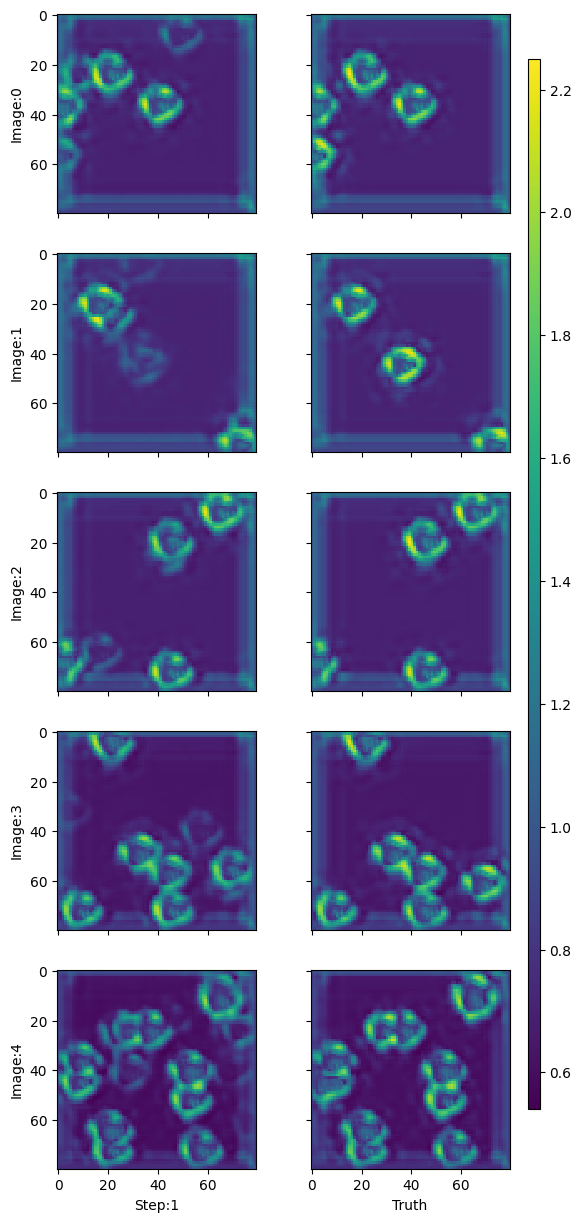

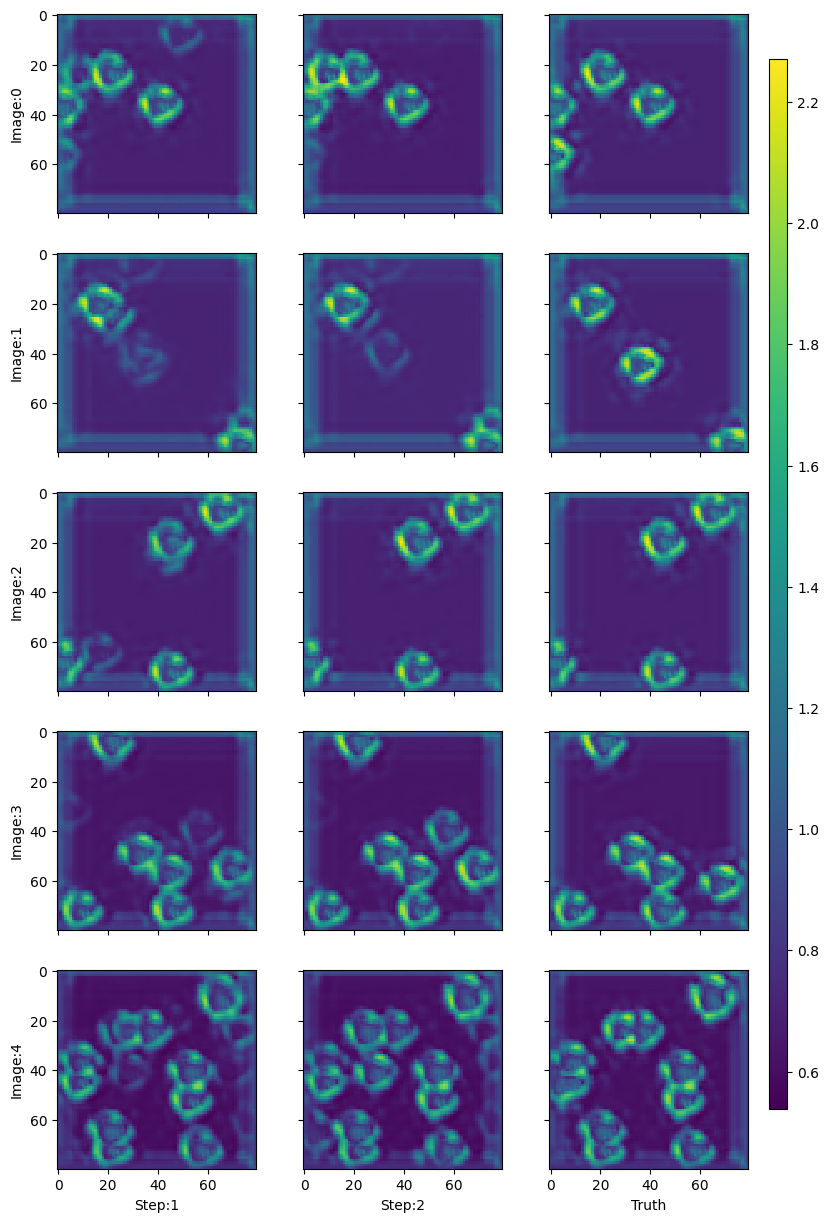

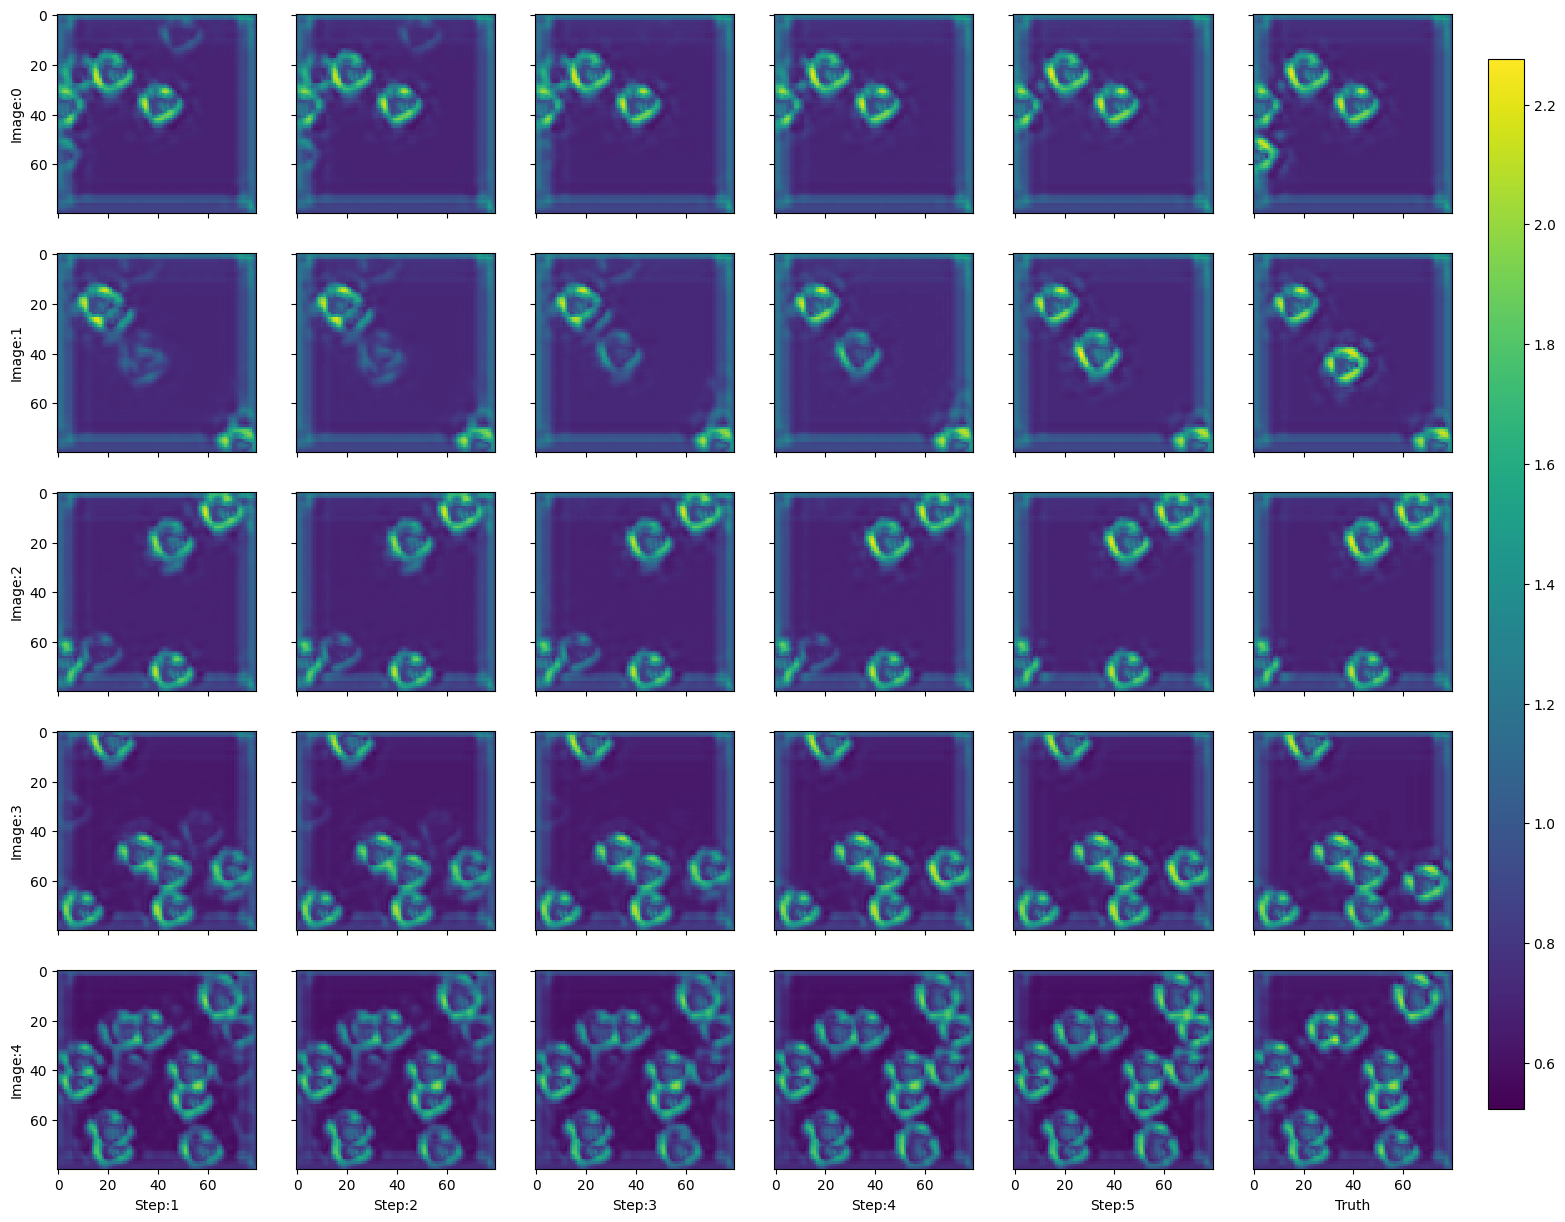

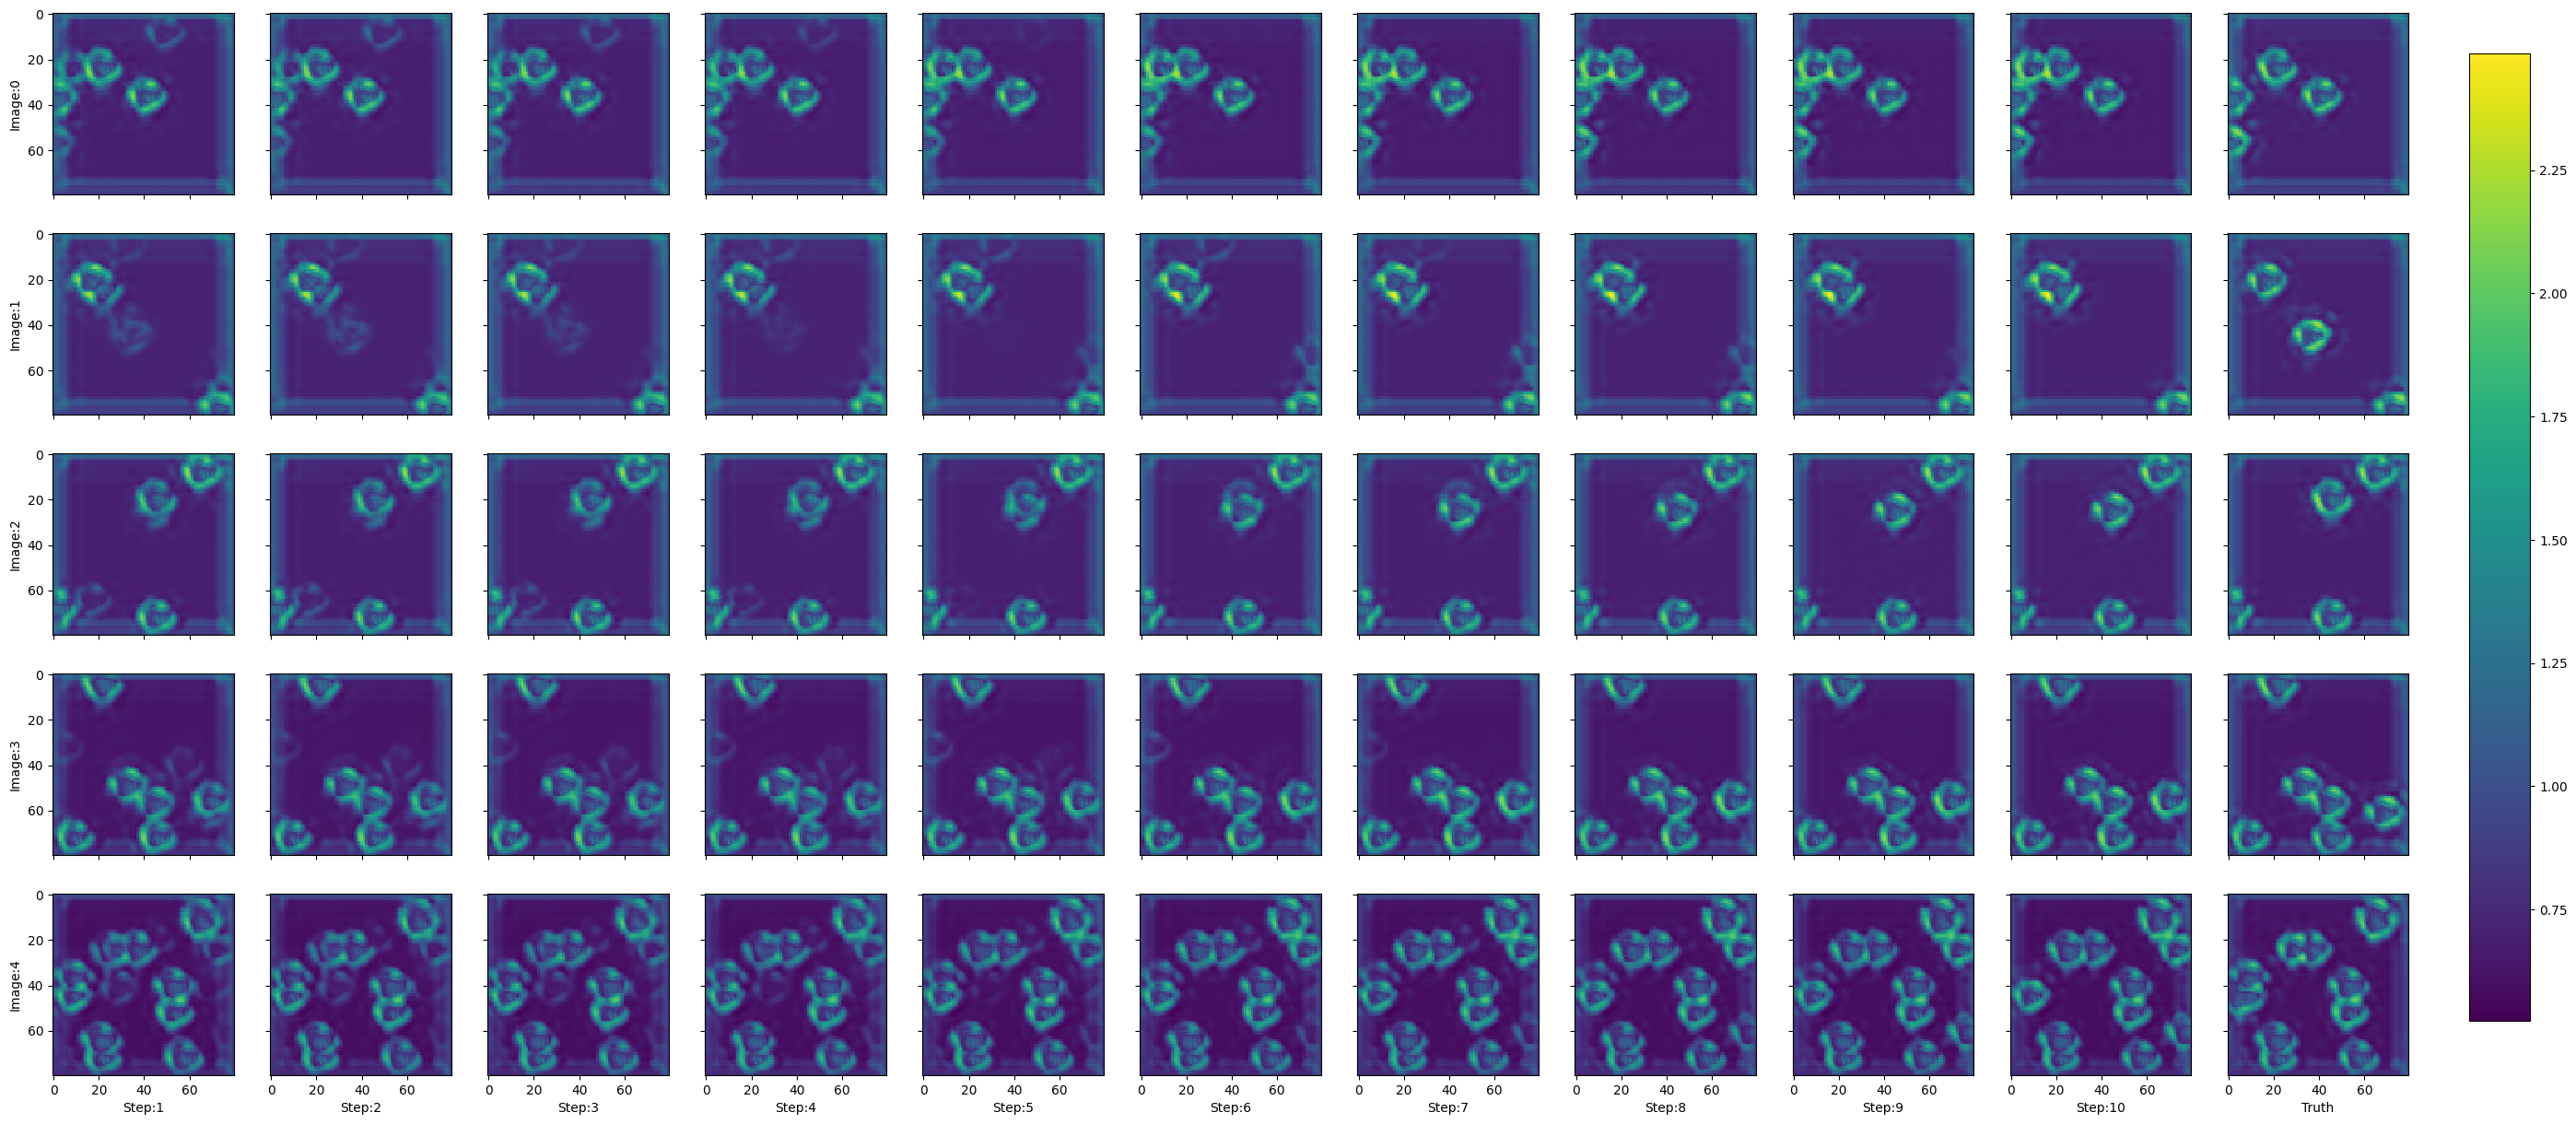

In [10]:
batch = next(dc2_val_dataloader_iter)
batch_on_device = move_data_to_device(batch, device=device)
for ddim_steps in [1, 2, 5, 10]:
    bliss_encoder.ddim_steps = ddim_steps
    bliss_encoder.detection_diffusion.sampling_timesteps = ddim_steps
    with torch.no_grad():
        _pred_cat_tile, inter_outputs = bliss_encoder.sample(batch_on_device, 
                                                            return_inter_output=True)
        pred_dict = bliss_encoder.debug_forward(batch_on_device)
    plot_diffusion_results(inter_outputs, pred_dict["inter_target"].cpu(), image_num=5)